<a href="INSERT_colab_python_link" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

label: exercise
# Exercise 1 (d)

Implement the GP with squared exponential kernel, zero mean function and $\ell = 1$ from scratch for $n=2$ observations $(\bm{y},\bm{x})$. 
Do this as efficiently as possible by explicitly calculating all expensive computations by hand. Do the same for the posterior predictive distribution of $y_*$. Test your implementation using simulated data.


label: math_solution
# Solution: Explicit Calculations

To implement a GP with squared exponential kernel and $\ell = 1$, we need the inverse of $\bm{K}$. $\bm{x}$ being a vector implies that we have only one feature and thus the entries of our matrix $\bm{K}$ are 
$$
\bm{K} = \begin{pmatrix} 1 & \exp(-0.5 (x^{(1)} - x^{(2)})^2) \\ \exp(-0.5 (x^{(2)} - x^{(1)})^2) & 1 \end{pmatrix}.
$$

The inverse of $\bm{K}$ is then given by:
$$
\frac{1}{1-\exp(-(x^{(1)} - x^{(2)})^2)} \begin{pmatrix} 1 & -\exp(-0.5 (x^{(1)} - x^{(2)})^2) \\ -\exp(-0.5 (x^{(2)} - x^{(1)})^2) & 1 \end{pmatrix}.
$$

If we have a noisy GP, we would have to add $\sigma^2 \bm{I}_2$ to $\bm{K}$ with resulting inverse:

$$
\bm{K}_y^{-1} = \frac{1}{(1+\sigma^2)^2-\exp(-(x^{(1)} - x^{(2)})^2)} \begin{pmatrix} 1+\sigma^2 & -\exp(-0.5 (x^{(1)} - x^{(2)})^2) \\ -\exp(-0.5 (x^{(2)} - x^{(1)})^2) & 1+\sigma^2 \end{pmatrix}.
$$


Assuming a zero mean GP, we can derive $\frac{\partial \bm{K}_y}{\partial \theta}$ with $\theta = \sigma^2$, which gives us the identity matrix. We can thus maximize the marginal likelihood (slide on [*Gaussian Process Training*](https://slds-lmu.github.io/i2ml/chapters/19_gaussian_processes/19-05-training/)), by finding $\sigma^2$ that yields:
$$\text{tr}\left( \bm{K}_y^{-1} \bm{y} \bm{y}^\top \bm{K}_y^{-1} - \bm{K}_y^{-1} \right) = 0.$$

This can be solved analytically (though quite tedious). We will use a root-finding function for this. For the posterior predictive distribution we can make use of the results from the previous exercise.

label: setup
# Code Setup

In [1]:
#| label: setup

# you may need to first run
# pip install numpy matplotlib scipy scikit-learn

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fsolve
from scipy.stats import multivariate_normal
from sklearn.gaussian_process.kernels import RBF


# set seed, define n, true (unknown) sigma
np.random.seed(509)
n = 2
sigma = 1

---
label: kernel_setup
---

# Kernel Function Definition

We define the squared exponential kernel functions with length scale $\ell = 1$.

In [2]:
#| label: kernel-functions

# define kernel with l = 1 (length scale)
def kernel_fun_pred(x, y): # K(x, y)
    assert x.ndim == 2 and y.ndim == 2, "x and y must be 2D arrays"
    kernel = RBF(length_scale=1.0)
    return kernel(x, y)

def kernel_fun(x):         # K(x, x) 
    return kernel_fun_pred(x, x)

# Examples
x_example = np.array([[0], [1]])
y_example = np.array([[0], [2], [3]])

print(f"K(x, y) =\n{kernel_fun_pred(x_example, y_example)}\n")


K(x, y) =
[[1.         0.13533528 0.011109  ]
 [0.60653066 0.60653066 0.13533528]]



label: data_gen
## Data Generation

We generate synthetic data according to the GP generating process. First, we sample input points $x$, then construct the kernel matrix $K$ and add noise to get $K_y$, and finally sample observations $y$ from the multivariate normal distribution.

In [3]:
#| label: data_gen

# draw data according to the generating process:
x = np.random.normal(size=n)    # sample input points
x = x.reshape(-1, 1)  # reshape to 2D array

K = kernel_fun(x)               # kernel matrix
K_y = K + sigma**2 * np.eye(2)  # adding noise to diagonal

# sampling from multivariate normal distribution
y = multivariate_normal.rvs(mean=np.zeros(n), cov=K_y).reshape(-1, 1)
print(y)

[[-0.44386155]
 [ 2.30799639]]


label: hyperparameter-optimization-explanation
# Hyperparameter Optimization

We implement the root-finding function to optimize the noise parameter $\sigma^2$ by setting the derivative of the marginal likelihood to zero. This corresponds to finding the root of the trace expression derived earlier.

In [4]:
#| label: optimize-hyperparameters

# function to find the best sigma^2
def root_fun(sigma_square):
    K_y_inv = np.linalg.inv(K + sigma_square * np.eye(2))
    
    term1 = K_y_inv @ y @ y.T @ K_y_inv
    term2 = K_y_inv
    trace_val = np.trace(term1 - term2)
    
    return 0.5 * trace_val

# get the best sigma using root finding
best_sigma_squared = fsolve(root_fun, 1)[0]  # 1 is just a starting point
print(f"Optimal sigma^2: {best_sigma_squared:.4f}")

Optimal sigma^2: 1.9843


label: optim_visualization
## Visualization of Optimization

We plot the marginal likelihood derivative as a function of $\sigma^2$ to visualize the optimization problem and show where the optimal value is found (where the derivative equals zero).

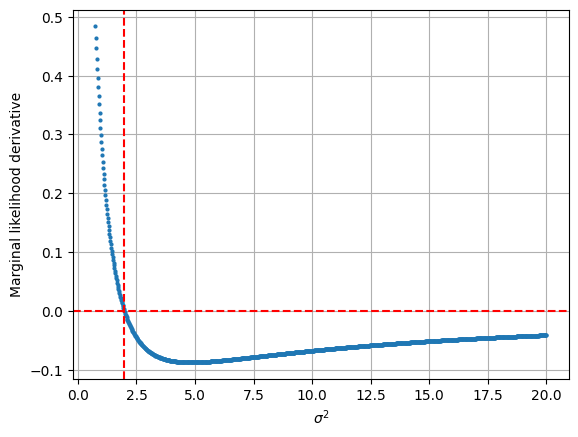

In [5]:
#| label: plot-optimization

# plot the optimization problem and best sigma
# note: lower bound for sigma^2 is set to 0.75 to avoid numerical issues
possible_sigma_vals = np.linspace(0.75, 20, 1_000)


# evaluate root function for all sigma values
root_values = [root_fun(sig) for sig in possible_sigma_vals]

plt.plot(possible_sigma_vals, root_values, 'o', markersize=2)

plt.xlabel(r'$\sigma^2$')
plt.ylabel('Marginal likelihood derivative')
plt.axhline(y=0, linestyle='--', color="red")  					 # horizontal line at y=0
plt.axvline(x=best_sigma_squared, linestyle='--',  color="red")  # optimal sigma (derivative = 0)
plt.grid(True)
plt.show()

label: posterior_predictiev
# Posterior Predictive Distribution

We implement a function to draw samples from the posterior predictive distribution. This uses the GP posterior mean and variance formulas to generate predictions at new input points $x^*$.

In [6]:
#| label: posterior-predictive-function

def draw_from_pred_posterior(num_samples, y, x, xstar, sigma_square=1):
    # invert noisy K
    K_y_inv = np.linalg.inv(kernel_fun(x) + sigma_square * np.eye(2))
    
    # get the other K's for new data
    Kstar = kernel_fun_pred(x, xstar)  # K(x, x*)
    Kstarstar = kernel_fun(xstar)  	   # K(x*, x*)
    
	# draw samples according to Ex. (d)
    post_mean = Kstar.T @ K_y_inv @ y
    post_var = Kstarstar - Kstar.T @ K_y_inv @ Kstar
    
    samples = np.random.normal(
        loc=post_mean.flatten(), 
        scale=np.sqrt(post_var.flatten()),  
        size=num_samples
    )
    
    return samples

label: sampling_visualization
## Sampling and Visualization

Finally, we draw samples from the posterior predictive distribution at a test point $x^* = 0$ using the optimized noise parameter, and visualize the distribution with a histogram.

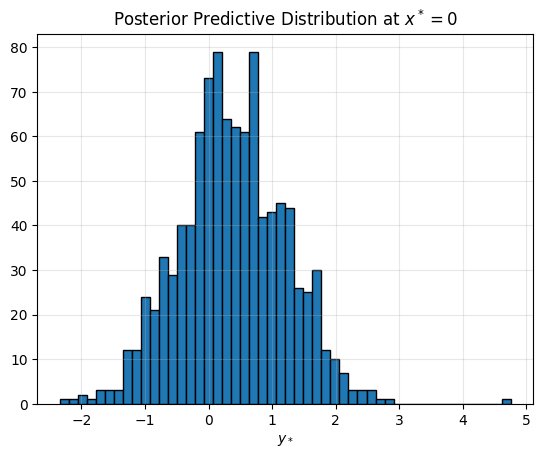

In [7]:
#| label: sample_and_plot

xstar = np.array([[0]])  # point where we want to predict

# draw enough samples to get a feeling for the distribution
samples_posterior = draw_from_pred_posterior(
    num_samples=1_000, 
    sigma_square=best_sigma_squared, 
    y=y, x=x, xstar=xstar
)

# plot the distribution
plt.hist(samples_posterior, bins=50, edgecolor='black')
plt.xlabel(r'$y_*$')
plt.title('Posterior Predictive Distribution at $x^* = 0$')
plt.grid(True, alpha=0.3)
plt.show()
